In [5]:
# pip install pandas numpy scikit-learn
# pip install matplotlib seaborn

In [6]:
import pandas as pd
import pickle
import numpy as np
import time
import os 

# 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.decomposition import NMF 

# 
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

print("所有库导入成功。")

所有库导入成功。


# Load Pre-processed Artifacts

In [7]:
# Load path
TOPICS_DF_FILE = "processed_papers_WITH_TOPICS.pkl"
TFIDF_MATRIX_FILE = "tfidf_matrix.pkl"
VECTORIZER_FILE = "tfidf_vectorizer.pkl"
NMF_MODEL_FILE = "nmf_model.pkl"

NUMBER_OF_TOPICS = 20
# --- 关键词数量 ---
NUMBER_OF_TOP_WORDS = 15

# --- 主题名称映射 ---
TOPIC_NAME_MAP = {
    0: "Stats Learning Theory",  # 统计学习理论
    1: "Spiking Models",  # 计算神经科学
    2: "RL Theory",  # 强化学习-理论
    3: "Deep Learning",  # 深度学习
    4: "Classic NN",  # 经典神经网络
    5: "Computer Vision",  # 计算机视觉
    6: "Clustering",  # 聚类算法
    7: "Kernel Methods / SVMs",  # 核方法
    8: "Supervised Learning",  # 监督/半监督学习
    9: "Graphical Models",  # 图模型
    10: "Online Learning / Bandits",  # 在线学习/赌博机
    11: "Bayesian Inference",  # 贝叶斯推断
    12: "Matrix/Tensor",  # 矩阵/张量方法
    13: "Optimization",  # 优化算法
    14: "NLP / Topic Models",  # 自然语言处理
    15: "Visual Neuroscience",  # 视觉神经科学
    16: "Hardware / Neuromorphic",  # 硬件/神经形态
    17: "Submodular Optimization",  # 子模优化
    18: "Game Theory",  # 博弈论
    19: "RL Agents"  # 强化学习-智能体
}



In [14]:
# --- load data ---
def load_data(topics_file, tfidf_file, vectorizer_file):

    print("--- 正在加载数据文件 (df, tfidf_matrix, vectorizer) ---")


    required_files = [topics_file, tfidf_file, vectorizer_file]
    files_exist = True
    for f in required_files:
        if not os.path.exists(f):
            print(f"!!! 错误: 找不到文件 '{f}'。")
            files_exist = False

    if not files_exist:
        return None, None, None

    try:
        df_final = pd.read_pickle(topics_file)
        print(f"成功加载: {topics_file} (形状: {df_final.shape})")

        with open(tfidf_file, 'rb') as f:
            tfidf_matrix = pickle.load(f)
            print(f"成功加载: {tfidf_file} (形状: {tfidf_matrix.shape})")

        with open(vectorizer_file, 'rb') as f:
            vectorizer = pickle.load(f)
            print(f"成功加载: {vectorizer_file}")

        # --- 修改: 只返回 3 个对象 ---
        return df_final, tfidf_matrix, vectorizer

    except Exception as e:
        print(f"--- [致命错误] 加载文件时出错: {e} ---")
        return None, None, None

# --- 3. 打印关键词函数 (不变) ---
def print_top_words(model, feature_names, n_top_words):
    print(f"\n--- Displaying the top {n_top_words} keywords for each topic ---")
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic #{topic_idx}: {', '.join(top_features)}")
    print("---------------------------------------------------\n")

def display_topic_keywords(nmf_model, vectorizer, n_top_words):
    print(" > 正在从模型中提取关键词...")
    try:
        tfidf_feature_names = vectorizer.get_feature_names_out()
    except AttributeError:
        tfidf_feature_names = vectorizer.get_feature_names()
    print_top_words(nmf_model, tfidf_feature_names, n_top_words)

# --- 4. 可视化函数 (t-SNE) (修改版) ---
def run_tsne_visualization(df_final, doc_topic_matrix, n_topics):
    """
    运行 t-SNE 可视化。
    """
    print("\n--- 步骤 5: 正在运行 t-SNE 可视化 ---")

    # 步骤 5.1: 运行 t-SNE 降维 (这会比较慢)
    print(" > 正在运行 t-SNE 降维 (这可能需要 1-2 分钟)...")
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        max_iter=1000,
        verbose=1
    )
    # --- 修改: 直接在传入的 doc_topic_matrix 上运行 ---
    tsne_results = tsne.fit_transform(doc_topic_matrix)
    print(" > t-SNE 降维完成！")

    # 步骤 5.2: 准备绘图数据
    print(" > 正在准备绘图 DataFrame...")
    plot_df = pd.DataFrame(tsne_results, columns=['tsne_x', 'tsne_y'])
    plot_df['topic_label'] = df_final['topic_label']
    plot_df['topic_id'] = df_final['topic_id']
    plot_df = plot_df.sort_values('topic_id')

    # 步骤 5.3: 绘图
    print(" > 正在绘制 t-SNE 散点图...")
    plt.figure(figsize=(14, 6))
    sns.scatterplot(
        x='tsne_x',
        y='tsne_y',
        hue='topic_label',
        palette=sns.color_palette("hsv", n_topics),
        data=plot_df,
        s=20,
        alpha=0.6,
        legend='full'
    )
    plt.title(f"NeurIPS Topics  t-SNE Visualization ( K = {n_topics} )", fontsize=16)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.legend(title='Topics', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig("tsne_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- 5. 可视化函数 (趋势分析) (不变) ---
def run_trend_analysis(df_final):
    print("\n--- 步骤 6: 正在运行主题趋势分析 ---")
    if 'year' not in df_final.columns:
        print("!!! 错误: 在 'df_final' 中未找到 'year' 列。")
        return
    print(" > 成功找到 'year' 列。")
    print(" > 正在按年份和主题统计论文数量...")
    df_trends = df_final[df_final['year'] > 0].copy()
    topic_trends_df = df_trends.groupby('year')['topic_label'].value_counts().unstack().fillna(0)
    print(" > 正在绘制主题趋势图...")
    fig, ax = plt.subplots(figsize=(14, 6))
    topic_trends_df.plot(
        kind='area',
        stacked=True,
        ax=ax,
        colormap='tab20'
    )
    ax.set_title('NeurIPS Trends in the Evolution of Thesis Topics Over Time', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Papers', fontsize=12)
    ax.legend(title='Topics', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig("topic_trends_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

print("所有辅助函数定义成功。")

所有辅助函数定义成功。


In [9]:
# --- 执行数据加载 ---
df_final, tfidf_matrix, vectorizer = load_data(
    TOPICS_DF_FILE,
    TFIDF_MATRIX_FILE,
    VECTORIZER_FILE
)

# 初始化变量，供后续单元格使用
nmf_model = None
doc_topic_matrix = None

if df_final is None:
    print("\n--- [错误] 数据加载失败，请检查文件路径和错误信息。---")
else:
    print("\n--- [成功] 所有数据文件已加载到内存中。 ---")

--- 正在加载数据文件 (df, tfidf_matrix, vectorizer) ---
成功加载: processed_papers_WITH_TOPICS.pkl (形状: (7238, 9))
成功加载: tfidf_matrix.pkl (形状: (7238, 479899))
成功加载: tfidf_vectorizer.pkl

--- [成功] 所有数据文件已加载到内存中。 ---


# Inspect Topic Keywords

In [10]:
# --- 步骤 2: 加载或训练 NMF 模型 ---
if df_final is not None:
    # 检查 NMF_MODEL_FILE (e.g., "nmf_model.pkl") 是否存在
    if os.path.exists(NMF_MODEL_FILE):

        # --- 方案 A: 加载已存在的模型 (快速) ---
        print(f"--- 正在加载已存在的 NMF 模型: {NMF_MODEL_FILE} ---")
        try:
            with open(NMF_MODEL_FILE, 'rb') as f:
                nmf_model = pickle.load(f)
            print(" > 模型加载成功。")

            # 检查加载的模型K值是否与设置一致
            if nmf_model.n_components != NUMBER_OF_TOPICS:
                print(f"!!! 警告: 加载的模型有 {nmf_model.n_components} 个主题,")
                print(f"     但你的常量设置为 {NUMBER_OF_TOPICS}。")
                print(f"     如果你想重新训练，请删除 '{NMF_MODEL_FILE}' 文件再运行。")

            # 我们需要 'doc_topic_matrix'
            print(" > 正在运行 NMF.transform() (非常快)...")
            doc_topic_matrix = nmf_model.transform(tfidf_matrix)
            print(" > 转换完成。")

        except Exception as e:
            print(f"!!! 加载模型失败: {e}。将尝试重新训练。")
            nmf_model = None # 确保触发 B 方案

    # --- 方案 B: 训练新模型 (缓慢) ---
    if nmf_model is None: # 如果加载失败或文件不存在
        print(f"--- 未找到模型文件 '{NMF_MODEL_FILE}' (或加载失败)。---")
        print(f"--- 正在训练新 NMF 模型 (K={NUMBER_OF_TOPICS}) ---")
        print("!!! (这会很慢，请耐心等待...) !!!")

        nmf_model = NMF(
            n_components=NUMBER_OF_TOPICS,
            random_state=42,
            init='nndsvda',
            l1_ratio=0.5,
            max_iter=500, # 这是耗时的部分
            solver='cd'
        )
        # 训练并转换
        doc_topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        print(" > NMF 训练完成。")

        # --- 关键步骤: 保存模型 ---
        try:
            with open(NMF_MODEL_FILE, "wb") as f:
                pickle.dump(nmf_model, f)
            print(f" > 成功！新模型已保存到: {NMF_MODEL_FILE}")
            print(" > (下次运行此单元格将会非常快)")
        except Exception as e:
            print(f"!!! 警告: 保存模型失败: {e}")

else:
    print("--- [跳过] 数据未加载，请先运行 '步骤 1'。 ---")

--- 正在加载已存在的 NMF 模型: nmf_model.pkl ---
 > 模型加载成功。
 > 正在运行 NMF.transform() (非常快)...
violation: 1.0
violation: 0.5426142557152248
violation: 0.08857197002132637
violation: 0.019876079557091482
violation: 0.00785550179929385
violation: 0.0023330781397966254
violation: 0.0006594346272997189
violation: 0.00029200881846436926
violation: 0.00010680547766423181
violation: 3.266519341927958e-05
Converged at iteration 11
 > 转换完成。


In [11]:
if df_final is not None:
    print("\n--- 步骤 3: 正在应用人工命名到 'topic_label' 列 ---")

    if 'topic_id' not in df_final.columns:
        print("!!! 错误: 'df_final' 中未找到 'topic_id' 列。")
    else:
        # 使用 .map() 函数，根据 'topic_id' 列创建新的 'topic_label'
        df_final['topic_label'] = df_final['topic_id'].map(TOPIC_NAME_MAP)

        if df_final['topic_label'].isnull().any():
            print("!!! 警告: 存在 'topic_id' 未在 TOPIC_NAME_MAP 中找到。")
            df_final['topic_label'] = df_final['topic_label'].fillna("Unmapped Topic")
        else:
            print(" > 成功将所有 topic_id 映射到新名称。")

        print(" > 命名映射示例:")
        print(df_final[['topic_id', 'topic_label']].head(3))
else:
    print("--- [跳过] 数据未加载，请先运行 '步骤 1'。 ---")


--- 步骤 3: 正在应用人工命名到 'topic_label' 列 ---
 > 成功将所有 topic_id 映射到新名称。
 > 命名映射示例:
   topic_id          topic_label
0         5      Computer Vision
1        15  Visual Neuroscience
2        15  Visual Neuroscience


# Topic Trend Analysis

In [12]:
if nmf_model is not None and vectorizer is not None:
    print("\n--- 步骤 4: 检查主题关键词 ---")
    display_topic_keywords(nmf_model, vectorizer, NUMBER_OF_TOP_WORDS)
else:
    print("--- [跳过] 模型或数据未加载。 ---")


--- 步骤 4: 检查主题关键词 ---
 > 正在从模型中提取关键词...

--- Displaying the top 15 keywords for each topic ---
Topic #0: bound, estim, theorem, sampl, distribut, risk, log, let, probabl, lemma, error, loss, proof, statist, xi
Topic #1: neuron, spike, fire, synapt, spike train, synaps, fire rate, time, postsynapt, membran, rate, activ, ms, membran potenti, presynapt
Topic #2: polici, reward, action, valu function, mdp, reinforc, state, reinforc learn, optim, polici gradient, optim polici, approxim, mdps, learn, algorithm
Topic #3: layer, deep, network, convolut, train, learn, arxiv, neural network, neural, architectur, dataset, gan, generat, cnn, dropout
Topic #4: network, unit, train, input, hidden, neural network, weight, neural, output, hidden unit, learn, layer, error, net, pattern
Topic #5: imag, object, featur, pixel, segment, patch, scene, detect, face, visual, recognit, shape, vision, color, textur
Topic #6: cluster, kmean, data, algorithm, point, partit, cluster algorithm, spectral cluster, s


--- 步骤 5: 正在运行 t-SNE 可视化 ---
 > 正在运行 t-SNE 降维 (这可能需要 1-2 分钟)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7238 samples in 0.001s...
[t-SNE] Computed neighbors for 7238 samples in 0.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7238
[t-SNE] Computed conditional probabilities for sample 2000 / 7238
[t-SNE] Computed conditional probabilities for sample 3000 / 7238
[t-SNE] Computed conditional probabilities for sample 4000 / 7238
[t-SNE] Computed conditional probabilities for sample 5000 / 7238
[t-SNE] Computed conditional probabilities for sample 6000 / 7238
[t-SNE] Computed conditional probabilities for sample 7000 / 7238
[t-SNE] Computed conditional probabilities for sample 7238 / 7238
[t-SNE] Mean sigma: 0.018406
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.796501
[t-SNE] KL divergence after 1000 iterations: 1.435055
 > t-SNE 降维完成！
 > 正在准备绘图 DataFrame...
 > 正在绘制 t-SNE 散点图...


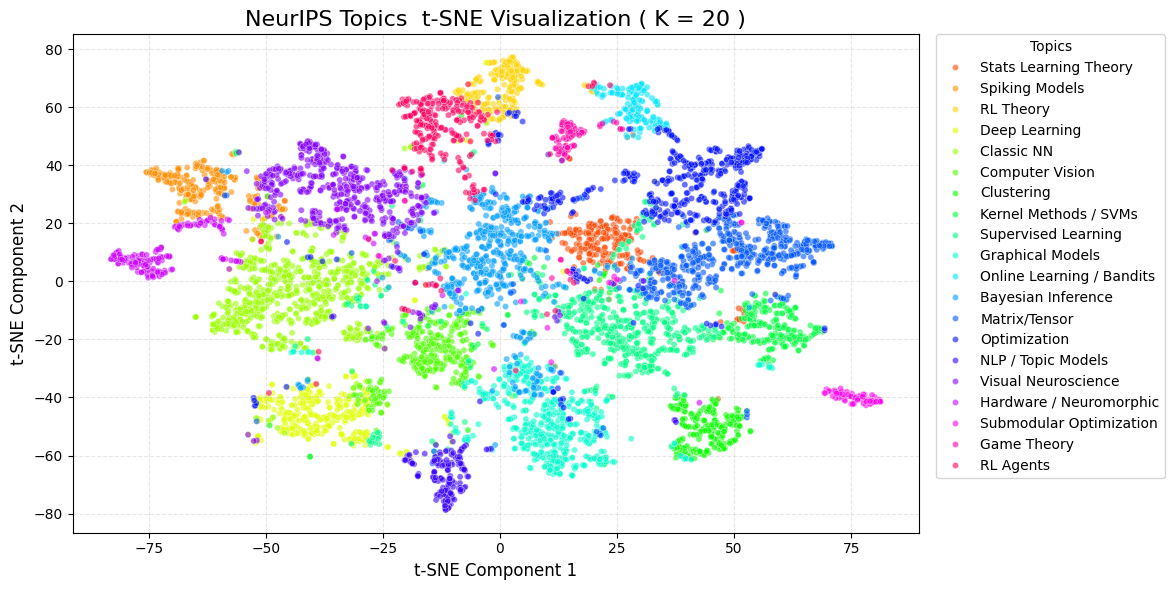

In [15]:
if df_final is not None and doc_topic_matrix is not None:
    # t-SNE 计算较慢，请耐心等待
    run_tsne_visualization(df_final, doc_topic_matrix, nmf_model.n_components)
else:
    print("--- [跳过] 数据或 'doc_topic_matrix' 未准备好。 ---")


--- 步骤 6: 正在运行主题趋势分析 ---
 > 成功找到 'year' 列。
 > 正在按年份和主题统计论文数量...
 > 正在绘制主题趋势图...


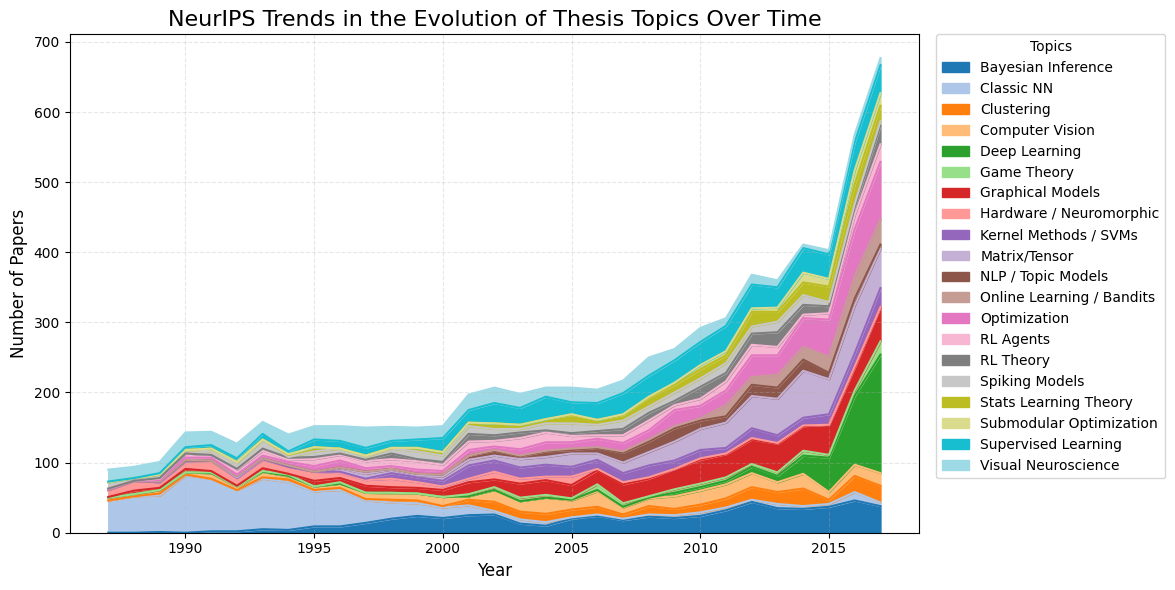

In [16]:
if df_final is not None:
    # 趋势分析非常快
    run_trend_analysis(df_final)
else:
    print("--- [跳过] 数据未加载。 ---")

# Evolution

In [ ]:
# 1. 使用 'explode' 将 authors_list 列表中的每个作者拆分为单独的行
#    我们只保留分析所需的列，以节省内存
df_exploded = df_final[['authors_list', 'topic_id', 'topic_label']].explode('authors_list')

# 2. 清理作者姓名 (去除可能存在的前后空格)
df_exploded['author_name'] = df_exploded['authors_list'].str.strip()

# 3. 移除空的作者姓名 (如果存在)
df_exploded = df_exploded[df_exploded['author_name'] != '']

print(f"原始论文数: {len(df_final)}")
print(f"'Explode' 后的总行数: {len(df_exploded)}")
print("Explode 后的数据示例:")
print(df_exploded[['author_name', 'topic_label']].head())

原始论文数: 7238
'Explode' 后的总行数: 20838
Explode 后的数据示例:
               author_name          topic_label
0           Hisashi Suzuki      Computer Vision
0           Suguru Arimoto      Computer Vision
1  Christopher L. Scofield  Visual Neuroscience
2        Patric K. Stanton  Visual Neuroscience
2    Terrence J. Sejnowski  Visual Neuroscience


: 

--- 步骤 9 (A): 高产作者的案例研究 ---
最高产的 10 位作者:
author_name
Michael I. Jordan        101
Bernhard Sch?lkopf        62
Yoshua Bengio             60
Geoffrey E. Hinton        58
Zoubin Ghahramani         51
Terrence J. Sejnowski     48
Peter Dayan               47
Alex J. Smola             41
Lawrence Carin            41
Andrew Y. Ng              39
Name: count, dtype: int64

--- 正在绘制 Top 5 作者的主题分布 ---


/tmp/ipython-input-133747219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')


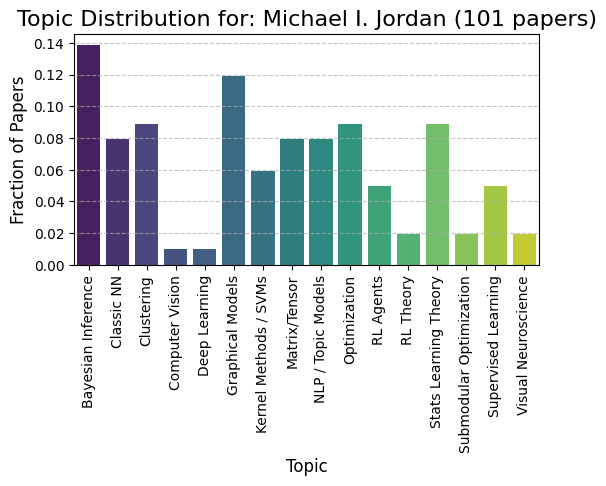

/tmp/ipython-input-133747219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')


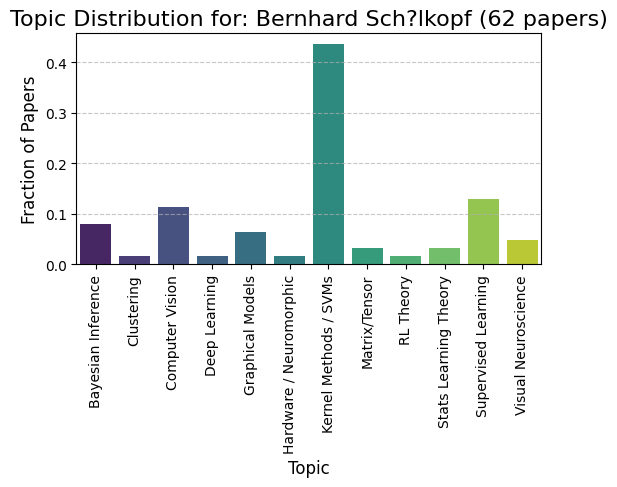

/tmp/ipython-input-133747219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')


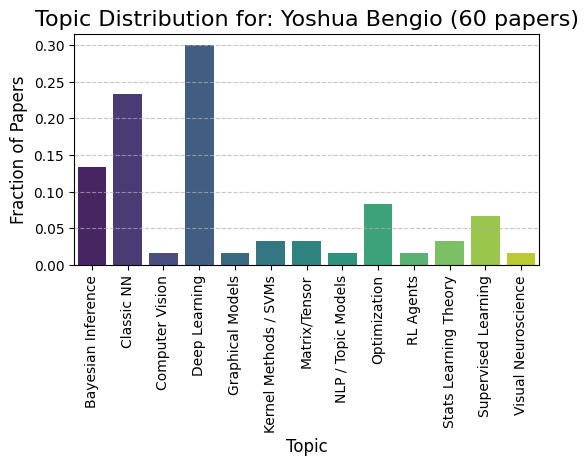

/tmp/ipython-input-133747219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')


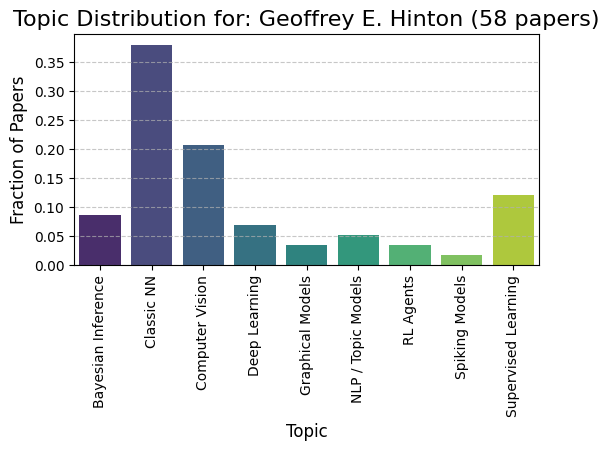

/tmp/ipython-input-133747219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')


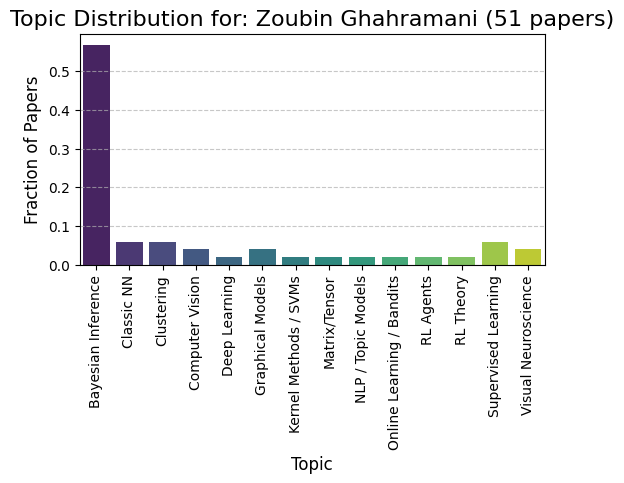

: 

In [ ]:
print("--- 步骤 9 (A): 高产作者的案例研究 ---")

# 1. 找到最高产的作者
prolific_authors = df_exploded['author_name'].value_counts()
print("最高产的 10 位作者:")
print(prolific_authors.head(10))

# 2. 选取前 5 位进行分析
TOP_AUTHORS_TO_CHECK = prolific_authors.head(5).index

print("\n--- 正在绘制 Top 5 作者的主题分布 ---")

for author in TOP_AUTHORS_TO_CHECK:
    # 筛选该作者的所有论文
    author_papers = df_exploded[df_exploded['author_name'] == author]
    total_papers = len(author_papers)

    # 统计主题分布 (按 topic_label 排序，使图表更整洁)
    topic_dist = author_papers['topic_label'].value_counts(normalize=True).sort_index()

    # 绘图
    plt.figure(figsize=(6, 3))
    sns.barplot(x=topic_dist.index, y=topic_dist.values, palette='viridis')
    plt.title(f"Topic Distribution for: {author} ({total_papers} papers)", fontsize=16)
    plt.ylabel("Fraction of Papers", fontsize=12)
    plt.xlabel("Topic", fontsize=12)
    plt.xticks(rotation=90) # 旋转 x 轴标签，因为主题名称很长
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
df_final

,year,title,abstract,paper_text,authors_list,processed_text,topic_id,topic_label
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hisashi Suzuki, Suguru Arimoto]","[selforgan, associ, databas, applic, hisashi, ...",5,Computer Vision
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[Christopher L. Scofield],"[mean, field, theori, layer, iv, visual, corte...",15,Visual Neuroscience
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[Patric K. Stanton, Terrence J. Sejnowski]","[store, covari, associ, longterm, potenti, dep...",15,Visual Neuroscience
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"[Gerhard Paass, J?rg Kindermann]","[bayesian, queri, construct, neural, network, ...",11,Bayesian Inference
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","[Anders Krogh, Jesper Vedelsby]","[neural, network, ensembl, cross, valid, activ...",4,Classic NN
...,...,...,...,...,...,...,...,...
7233,1994,Single Transistor Learning Synapses,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...,"[Paul E. Hasler, Chris Diorio, Bradley A. Minc...","[singl, transistor, learn, synaps, paul, hasle...",16,Hardware / Neuromorphic
7234,1994,"Bias, Variance and the Combination of Least Sq...",Abstract Missing,"Bias, Variance and the Combination of\nLeast S...",[Ronny Meir],"[bias, varianc, combin, least, squar, estim, r...",11,Bayesian Inference
7235,1994,A Real Time Clustering CMOS Neural Engine,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....,"[Teresa Serrano-Gotarredona, Bernab? Linares-B...","[real, time, cluster, cmos, neural, engin, ser...",16,Hardware / Neuromorphic
7236,1994,Learning direction in global motion: two class...,Abstract Missing,Learning direction in global motion: two\nclas...,"[V. Sundareswaran, Lucia M. Vaina]","[learn, direct, global, motion, two, class, ps...",15,Visual Neuroscience


: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# --- 准备 X 和 y ---

# X 是你用来训练 NMF 的同一个 TF-IDF 矩阵
# 确保 tfidf_matrix 变量在你的内存中！
if 'tfidf_matrix' not in locals():
    print("!!! 错误: 'tfidf_matrix' 变量未找到。")
    print("     请确保在运行 NMF 之前的单元格中已定义了 tfidf_matrix")
else:
    X = tfidf_matrix

    # y 是你的主题标签 (数字)
    y = df_final['topic_id']

    # 检查 X 和 y 的形状是否匹配
    print(f"特征 X 的形状: {X.shape}")
    print(f"标签 y 的形状: {y.shape}")

    # --- 划分训练集和测试集 ---
    # 我们使用 80% 训练，20% 测试
    # stratify=y 保证了在训练集和测试集中，每个主题的比例是均衡的 (非常重要!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"\n训练集大小: {X_train.shape}")
    print(f"测试集大小: {X_test.shape}")

特征 X 的形状: (7238, 479899)
标签 y 的形状: (7238,)

训练集大小: (5790, 479899)
测试集大小: (1448, 479899)


: 

In [ ]:
print("--- 正在训练: 逻辑回归 (Logistic Regression) ---")
print("(这可能需要一点时间...)")

# 1. 初始化模型
# solver='saga' 非常适合大型稀疏数据集
# max_iter=1000 确保它有足够的时间收敛
log_model = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42,
    n_jobs=-1 # 使用所有 CPU 核心
)

# 2. 训练模型
log_model.fit(X_train, y_train)

# 3. 预测测试集
y_pred_log = log_model.predict(X_test)

# 4. 评估
print(f"逻辑回归 (Recommended) 总体准确率: {accuracy_score(y_test, y_pred_log):.4f}")
print("\n详细分类报告 (Classification Report):")
print(classification_report(y_test, y_pred_log, target_names=TOPIC_NAME_MAP.values()))

--- 正在训练: 逻辑回归 (Logistic Regression) ---
(这可能需要一点时间...)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


逻辑回归 (Recommended) 总体准确率: 0.8681

详细分类报告 (Classification Report):
                           precision    recall  f1-score   support

    Stats Learning Theory       0.89      0.67      0.76        51
           Spiking Models       0.91      0.76      0.83        54
                RL Theory       0.86      0.86      0.86        44
            Deep Learning       0.96      0.90      0.93        77
               Classic NN       0.83      0.97      0.89       156
          Computer Vision       0.93      0.90      0.92        73
               Clustering       0.98      0.82      0.89        51
    Kernel Methods / SVMs       1.00      0.89      0.94        57
      Supervised Learning       0.78      0.95      0.86       124
         Graphical Models       0.89      0.96      0.92       113
Online Learning / Bandits       0.93      0.82      0.88        34
       Bayesian Inference       0.78      0.96      0.86       116
            Matrix/Tensor       0.83      0.94      0.88      

: 

In [ ]:
# df_final.to_csv(
#     'df_final_with_topics.csv',
#     index=False,
#     encoding='utf-8-sig'
# )

: 